In [692]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_algorithms.utils import algorithm_globals
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import sklearn.metrics.cluster as cluster_metrics
import numpy as np
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.manifold import TSNE
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
import torch
from torch import nn
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
import math

# SEED

In [693]:
# Set all needed seed
import random
import numpy as np
import torch
import os

def set_seed(seed=42):
    """
    Set seed for reproducibility
    Args:
        seed (int): Seed value
    """
    # Python random
    random.seed(seed)
    
    # Numpy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # CUDA deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Qiskit determinism
    algorithm_globals.random_seed = seed
    
    # Environment variables
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## UTILS

In [694]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print("CUDA Available:  ", torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {color.BOLD} {str(device).upper()} {color.END} Acceleration")

CUDA Available:   False
Using  CPU  Acceleration


In [695]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster_metrics.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def evaluate_clustering(X, pred_y, true_y):
    print(f"{'Silhouette:':15s}{silhouette_score(X, pred_y):2.3f}")
    print(f"{'Purity:':15s}{purity_score(true_y, pred_y):2.3f}")

def evaluate_clustering_table(X, pred_y, true_y):
    return silhouette_score(X, pred_y), purity_score(true_y, pred_y)

# DATASET IMPORT

In [696]:
INITIAL_TRAINING_SAMPLES = 400


MNIST_base_transform = transforms.Compose([
transforms.ToTensor()
])


MNIST_dataset_train = datasets.MNIST(root="quantum_metric_learning-master/data/dataset/MNIST", train=True, download=True, transform=MNIST_base_transform)
MNIST_dataset_test = datasets.MNIST(root="quantum_metric_learning-master/data/dataset/MNIST", train=False, download=True, transform=MNIST_base_transform)


if False:
    index01 = MNIST_dataset_train.train_labels <= 1
    MNIST_dataset_train.data = MNIST_dataset_train.data[index01]
    MNIST_dataset_train.targets = MNIST_dataset_train.targets[index01]

    index01_test = MNIST_dataset_test.train_labels <= 1
    MNIST_dataset_test.data = MNIST_dataset_test.data[index01_test]
    MNIST_dataset_test.targets = MNIST_dataset_test.targets[index01_test]




print(f"FULL DATASET INFO")
print(f"Image shape            : {MNIST_dataset_train.data.shape}")
print(f"Total training samples : {len(MNIST_dataset_train)}")
print(f"Total test     samples : {len(MNIST_dataset_test)}")
print("")

init_train_data, _, init_train_target, _ = train_test_split(
    range(len(MNIST_dataset_train)), 
    MNIST_dataset_train.targets,
    random_state=42,
    stratify=MNIST_dataset_train.targets,
    test_size=len(MNIST_dataset_train)- INITIAL_TRAINING_SAMPLES)


X = MNIST_dataset_train.data[init_train_data].numpy().astype("float32") / 255
y = MNIST_dataset_train.targets[init_train_data].numpy().astype("float32") 

print("TRAINING DATA INFO")
print(f"Image shape            : {X.shape}")
print(f"Total training samples : {len(X)}")
print("")


'''
init_test_data, _, init_test_target, _ = train_test_split(
    range(len(MNIST_dataset_test)), 
    MNIST_dataset_test.targets,
    random_state=42,
    stratify=MNIST_dataset_test.targets,
    test_size=len(MNIST_dataset_test)- INITIAL_TESTING_SAMPLES)
'''

X_test = MNIST_dataset_test.data.numpy().astype("float32") / 255
y_test = MNIST_dataset_test.targets.numpy().astype("float32")

print("TESTING DATA INFO")
print(f"Image shape            : {X_test.shape}")
print(f"Total training samples : {len(X_test)}")
print("")



FULL DATASET INFO
Image shape            : torch.Size([60000, 28, 28])
Total training samples : 60000
Total test     samples : 10000

TRAINING DATA INFO
Image shape            : (400, 28, 28)
Total training samples : 400

TESTING DATA INFO
Image shape            : (10000, 28, 28)
Total training samples : 10000



In [697]:
class MNIST_Distance_Dataset_Triplet_Loss(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.kers = np.ones((self.data.shape[0], self.data.shape[0]))
        self.output_transform = transforms.ToTensor()
        self.len = len(self.target)
        self.classes = {i:(np.where(self.target == i)[0], np.where(self.target != i)[0] ) for i in range(10)}


    def __getitem__(self, idx):
        return self.get_anchor(idx), self.get_positive(idx), self.get_negative(idx)
    
    def get_anchor(self, idx):
        return self.output_transform(self.data[idx])
    

    def get_positive(self, idx):
        i = np.random.choice(self.classes[self.target[idx]][0])
        return self.output_transform(self.data[i])
    
    def get_negative(self, idx):
        i = np.random.choice(self.classes[self.target[idx]][1])
        return self.output_transform(self.data[i])


    def get_order(self):
        return self.target.argsort()


    def ordered_pairwise(self):
        return self.kers[:,self.get_order()][self.get_order(),:]


    def get_flatten(self):
        return self.data.reshape((self.data.shape[0], self.data.shape[1]**2))


    def __len__(self):
        return self.len

300
100


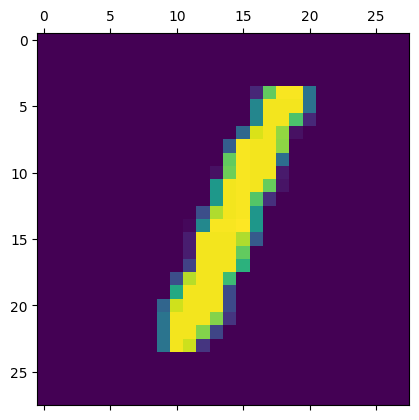

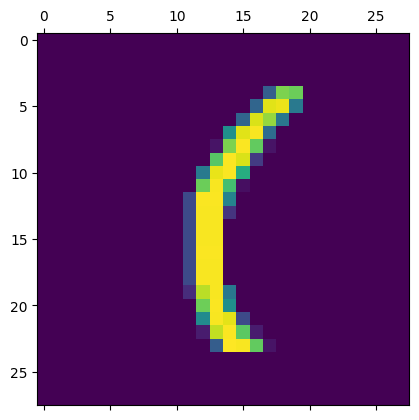

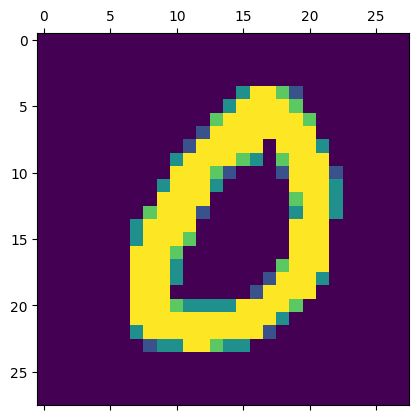

In [698]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
t = MNIST_Distance_Dataset_Triplet_Loss(X_train, y_train)
v = MNIST_Distance_Dataset_Triplet_Loss(X_val, y_val)
#stampa lunghezza del dataset

print(len(t))
print(len(v))

anchor, pos, neg = t[0]


plt.matshow(anchor.squeeze(0))
plt.matshow(pos.squeeze(0))
plt.matshow(neg.squeeze(0))



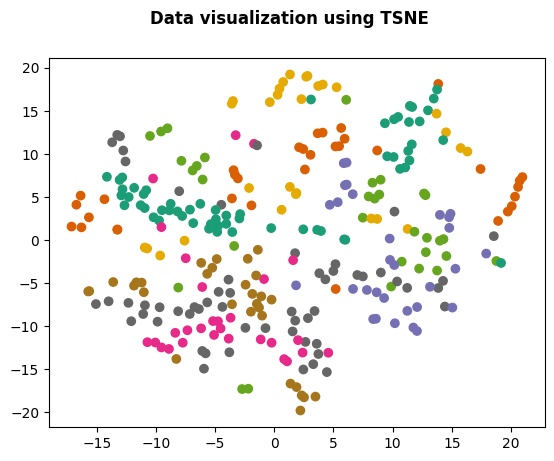

In [699]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t.get_flatten(), t.target)

fig, ax = plt.subplots()
fig.suptitle("Data visualization using TSNE", weight="bold")
ax.scatter(vis_x[:,0], vis_x[:,1], c=t.target, cmap='Dark2')

# ENCODERS


### Amplitude encoding

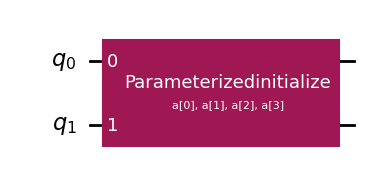

In [700]:
'''
Amplitude encoding, richiede nlog2 features
'''
def amplitude_encoding(n_features, param_name):
  qc = RawFeatureVector(n_features)
  qc = qc.assign_parameters(ParameterVector(param_name, n_features))
  qc.name = f"Amplitude Encoding {param_name}"
  return qc

amplitude_encoding(4, "a").draw(output="mpl")

### YZ angles encoding

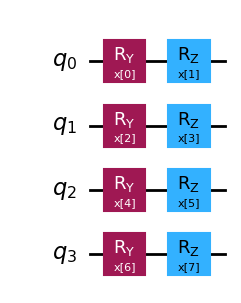

In [701]:
def yz_angles_encoding(n_features, param_name="x", params=None):
  """
  Encoding YZ con rotazioni RY e RZ.
  
  Args:
      n_features: numero di feature
      param_name: nome dei parametri (crea un nuovo ParameterVector)
      params: ParameterVector esistente da riutilizzare
  
  Nota: Specificare uno solo tra param_name e params
  """
  if params is None:
    params = ParameterVector(param_name, n_features)
  
  n_qubit = math.ceil(n_features / 2)
  qc = QuantumCircuit(n_qubit, name=f"Angles Encoding")
  gates = [qc.ry, qc.rz]

  for i in range(n_qubit):
    for gate_i in range(2):
      pindex = i*2 + gate_i
      if pindex < n_features:
        gates[gate_i](params[pindex], i)

  return qc

yz_angles_encoding(8, param_name="x").draw(output="mpl")

### Pooling layer

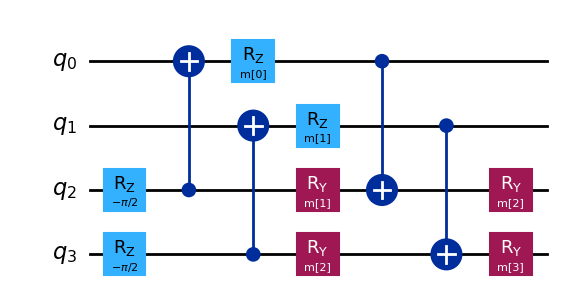

In [702]:
def pooling_layer(in_lane, param_prefix="pool"):
  qc = QuantumCircuit(in_lane, name="Pooling Layer")
  params = ParameterVector(param_prefix, length=in_lane //2 *3)

  for i in range(in_lane//2):
    current = i
    aux = i+ in_lane//2

    base_param =  current*(in_lane//2 -1)

    qc.rz(-np.pi/2, aux)
    qc.cx(aux, current)
    qc.rz(params[base_param + 0], current)
    qc.ry(params[base_param + 1], aux)
    qc.cx(current, aux)
    qc.ry(params[base_param + 2], aux)

  return qc

pooling_layer(4, param_prefix="m").draw(output="mpl")

# MODIFICHE ENCODING


### HRyRx encoding

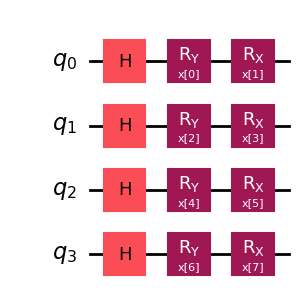

In [703]:
#Modifiche PROF
def hRyRx_encoding(n_features):
  # qubits
  n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  # feature extracted from neural network
  n_feature = n_features
  feature_map = QuantumCircuit(n_qubits)
  input_params = ParameterVector(name='x', length=n_feature)
  idx = 0
  for i in range(n_qubits):
      feature_map.h(i)
      feature_map.ry(input_params[idx], i)
      feature_map.rx(input_params[idx+1], i)
      idx +=2

  return feature_map

hRyRx_encoding(8).draw(output="mpl")


### HRyRz encoding

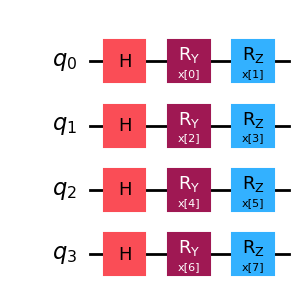

In [704]:
def hRyRz_encoding(n_features):
  # qubits
  n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  # feature extracted from neural network
  n_feature = n_features
  feature_map = QuantumCircuit(n_qubits)
  input_params = ParameterVector(name='x', length=n_feature)
  idx = 0
  for i in range(n_qubits):
      feature_map.h(i)
      feature_map.ry(input_params[idx], i)
      feature_map.rz(input_params[idx+1], i)
      idx +=2
  return feature_map

hRyRz_encoding(8).draw(output="mpl")

### X angles encoding

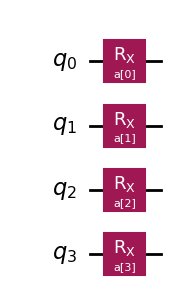

In [705]:
def x_angles_encoding(n_features, param_name):
  params = ParameterVector(param_name, n_features)
  n_qubit = n_features
  qc = QuantumCircuit(n_qubit, name=f"Angles Encoding {param_name}")
  

  for i in range(n_qubit):
    qc.rx(params[i], i)

  return qc

x_angles_encoding(4, "a").draw(output="mpl")

### RxRy encoding

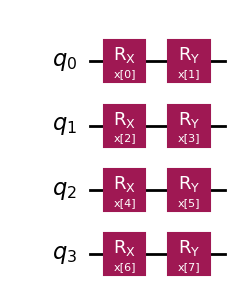

In [706]:
def RxRy_encoding(n_features, params=None):
  """
  Encoding RxRy con rotazioni RX e RY.
  
  Args:
      n_features: numero di feature
      params: ParameterVector da utilizzare (se None, ne crea uno nuovo con nome 'x')
  """
  if params is None:
      params = ParameterVector(name='x', length=n_features)
  
  n_qubits = math.ceil(n_features / 2)
  feature_map = QuantumCircuit(n_qubits)
  idx = 0
  
  for i in range(n_qubits):
      if idx < n_features:
          feature_map.rx(params[idx], i)
      if idx + 1 < n_features:
          feature_map.ry(params[idx + 1], i)
      idx += 2
  
  return feature_map

RxRy_encoding(8).draw(output="mpl")

### RxRz encoding

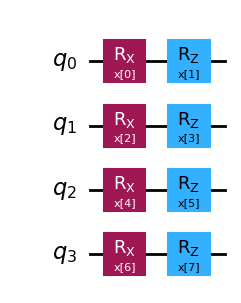

In [707]:
def RxRz_encoding(n_features, params=None):
  """
  Encoding RxRz con rotazioni RX e RZ.
  
  Args:
      n_features: numero di feature
      params: ParameterVector da utilizzare (se None, ne crea uno nuovo con nome 'x')
  """
  if params is None:
      params = ParameterVector(name='x', length=n_features)
  
  n_qubits = math.ceil(n_features / 2)
  feature_map = QuantumCircuit(n_qubits)
  idx = 0
  
  for i in range(n_qubits):
      if idx < n_features:
          feature_map.rx(params[idx], i)
      if idx + 1 < n_features:
          feature_map.rz(params[idx + 1], i)
      idx += 2
  
  return feature_map

RxRz_encoding(8).draw(output="mpl")

### RyRx encoding

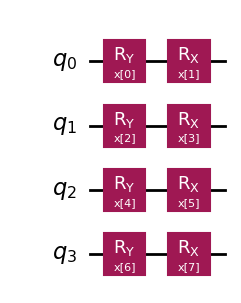

In [708]:
def RyRx_encoding(n_features, params=None):
  """
  Encoding RyRx con rotazioni RY e RX.
  
  Args:
      n_features: numero di feature
      params: ParameterVector da utilizzare (se None, ne crea uno nuovo con nome 'x')
  """
  if params is None:
      params = ParameterVector(name='x', length=n_features)
  
  n_qubits = math.ceil(n_features / 2)
  feature_map = QuantumCircuit(n_qubits)
  idx = 0
  
  for i in range(n_qubits):
      if idx < n_features:
          feature_map.ry(params[idx], i)
      if idx + 1 < n_features:
          feature_map.rx(params[idx + 1], i)
      idx += 2
  
  return feature_map

RyRx_encoding(8).draw(output="mpl")

### RzRx encoding

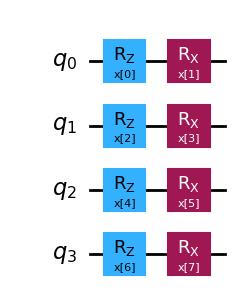

In [709]:
def RzRx_encoding(n_features, params=None):
  """
  Encoding RzRx con rotazioni RZ e RX.
  
  Args:
      n_features: numero di feature
      params: ParameterVector da utilizzare (se None, ne crea uno nuovo con nome 'x')
  """
  if params is None:
      params = ParameterVector(name='x', length=n_features)
  
  n_qubits = math.ceil(n_features / 2)
  feature_map = QuantumCircuit(n_qubits)
  idx = 0
  
  for i in range(n_qubits):
      if idx < n_features:
          feature_map.rz(params[idx], i)
      if idx + 1 < n_features:
          feature_map.rx(params[idx + 1], i)
      idx += 2
  
  return feature_map

RzRx_encoding(8).draw(output="mpl")

### Nonlinear full entanglement encoding

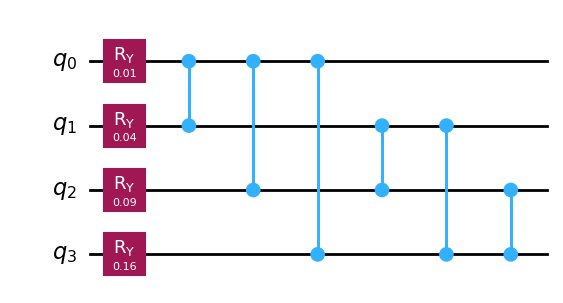

In [710]:
def feature_map_nonlinear_full_entaglement(num_features, params):
    """Feature map con non linearità (quadratiche) e full entaglement"""
    qc = QuantumCircuit(num_features)
    for i in range(num_features):
        qc.ry(params[i] ** 2, i)
    for i in range(num_features):
        for j in range(i + 1, num_features):
            qc.cz(i, j)
    return qc

feature_map_nonlinear_full_entaglement(4, [0.1, 0.2, 0.3, 0.4]).draw(output='mpl')

### Standard Reuploading Encoding

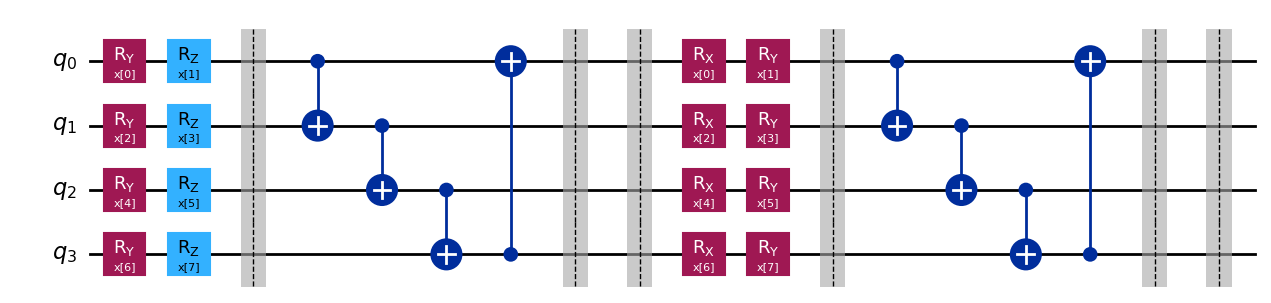

In [711]:
def standard_reuploading_encoding(n_features, param_name="x", layers=3):
    """
    Standard Data Reuploading: i dati vengono caricati più volte nel circuito
    in layer successivi con encoding diversi e entanglement.
    Solo encoding e CNOT, nessun ansatz.
    
    Struttura (repeating cycle):
    - Layer 0, 3, 6, ...: yz_angles_encoding (RY, RZ)
    - Layer 1, 4, 7, ...: RxRy_encoding (RX, RY)
    - Layer 2, 5, 8, ...: RzRx_encoding (RZ, RX)
    
    Args:
        n_features: numero di feature in input
        param_name: nome dei parametri
        layers: numero di layer di reuploading (default=3)
    
    Returns:
        QuantumCircuit con standard reuploading
    """
    n_qubits = math.ceil(n_features / 2)
    qc = QuantumCircuit(n_qubits, name=f"Standard Reuploading")
    params = ParameterVector(param_name, n_features)
    
    for layer in range(layers):
        # Encoder sequence repeats cyclically
        encoder_choice = layer % 3
        
        if encoder_choice == 0:
            # YZ encoding (RY, RZ)
            encoder_block = yz_angles_encoding(n_features, params=params)
                
        elif encoder_choice == 1:
            # RX-RY encoding (RX, RY)
            encoder_block = RxRy_encoding(n_features, params=params)
                
        else:
            # RZ-RX encoding (RZ, RX)
            encoder_block = RzRx_encoding(n_features, params=params)

        qc.compose(encoder_block, inplace=True)
        qc.barrier()
        
        # Entanglement layer con CNOT
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)
        
        # Entanglement circolare
        if n_qubits > 2:
            qc.cx(n_qubits - 1, 0)
        
        qc.barrier()
        qc.barrier()
    
    return qc

# Test del circuito
standard_reuploading_encoding(8, param_name="x", layers=2).draw(output="mpl")

### Partial Reuploading Encoding

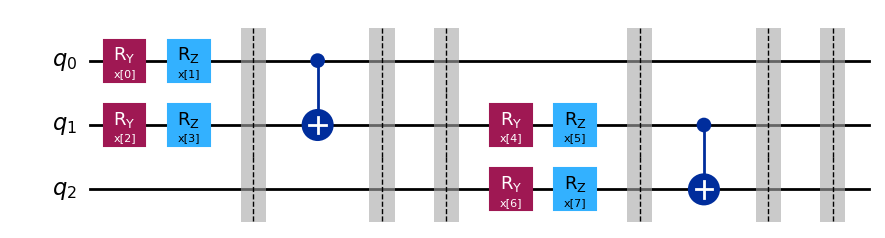

In [712]:
def partial_reuploading_encoding(n_features, layers=3, features_per_layer=4):
    """
    Partial Data Reuploading con finestra scorrevole sequenziale e wrapping ciclico.
    Ogni layer carica feature DIVERSE su qubit sovrapposti in modo sequenziale.
    Il ciclo di feature è determinato da layers * features_per_layer e ricomincia.
    Solo encoding (RY, RZ) ed entanglement (CNOT), nessun ansatz.
    
    Esempio con 3 layer, 4 feature/layer:
    - Layer 0: feature 0-3  → qubit (0,1)
    - Layer 1: feature 4-7  → qubit (1,2)  
    - Layer 2: feature 0-3  → qubit (2,3)  [restarts from beginning]
    Ciclo totale: 8 feature, indipendentemente da n_features
    
    Args:
        n_features: numero TOTALE di feature disponibili (deve essere >= features_per_layer)
        layers: numero di blocchi di encoding
        features_per_layer: quante feature caricare in ogni layer (deve essere pari)
    
    Returns:
        QuantumCircuit con partial reuploading sequenziale con wrapping
    """
    # Assicurati che le feature per layer siano un numero pari
    if features_per_layer % 2 != 0:
        features_per_layer += 1
        print(f"Adattato features_per_layer a {features_per_layer} per l'encoding a coppie.")
    
    # Calcolo del ciclo totale di feature (indipendente da n_features)
    total_cycle = layers * features_per_layer
    
    # Assicurati che n_features sia sufficiente per una iterazione del ciclo
    if n_features < features_per_layer:
        raise ValueError(f"n_features ({n_features}) deve essere >= features_per_layer ({features_per_layer})")
    
    # Calcolo del numero di qubit necessari per la finestra scorrevole
    n_qubits_per_encoding = math.ceil(features_per_layer / 2)
    n_qubits = n_qubits_per_encoding + (layers - 1)
    
    # Inizializziamo il circuito con ciclo indipendente da n_features
    qc = QuantumCircuit(n_qubits, name="Partial Reuploading Sequential")
    input_params = ParameterVector("x", total_cycle)
    
    for layer in range(layers):
        # Calcola l'offset dei qubit per questo layer (finestra scorrevole)
        qubit_offset = layer
        
        # Calcola l'indice di partenza delle feature per questo layer (cicla su total_cycle)
        start_feature_idx = (layer * features_per_layer) % total_cycle
        
        # Carica il blocco di feature sui qubit della finestra corrente con wrapping ciclico
        feature_idx = 0
        for i in range(n_qubits_per_encoding):
            qubit_target = qubit_offset + i
            
            # Calcola gli indici delle feature con wrapping ciclico su total_cycle
            p_idx_1 = (start_feature_idx + feature_idx) % total_cycle
            p_idx_2 = (start_feature_idx + feature_idx + 1) % total_cycle
            
            # Applica i gate di encoding
            qc.ry(input_params[p_idx_1], qubit_target)
            qc.rz(input_params[p_idx_2], qubit_target)
            
            feature_idx += 2

        qc.barrier()
        
        # Entanglement layer sui qubit di questo layer
        qubits_in_layer = list(range(qubit_offset, qubit_offset + n_qubits_per_encoding))
        for i in range(len(qubits_in_layer) - 1):
            qc.cx(qubits_in_layer[i], qubits_in_layer[i + 1])
        
        # Entanglement circolare (opzionale, solo se ci sono più di 2 qubit)
        if len(qubits_in_layer) > 2:
            qc.cx(qubits_in_layer[-1], qubits_in_layer[0])
        
        qc.barrier()
        qc.barrier()
    
    return qc

# Test del circuito - ciclo di 8 feature (2 layer * 4 feature/layer), stesso con n_features=24, 12, 8, ecc.
partial_reuploading_encoding(n_features=12, layers=2, features_per_layer=4).draw(output="mpl")

# ANSATZ

### MPS


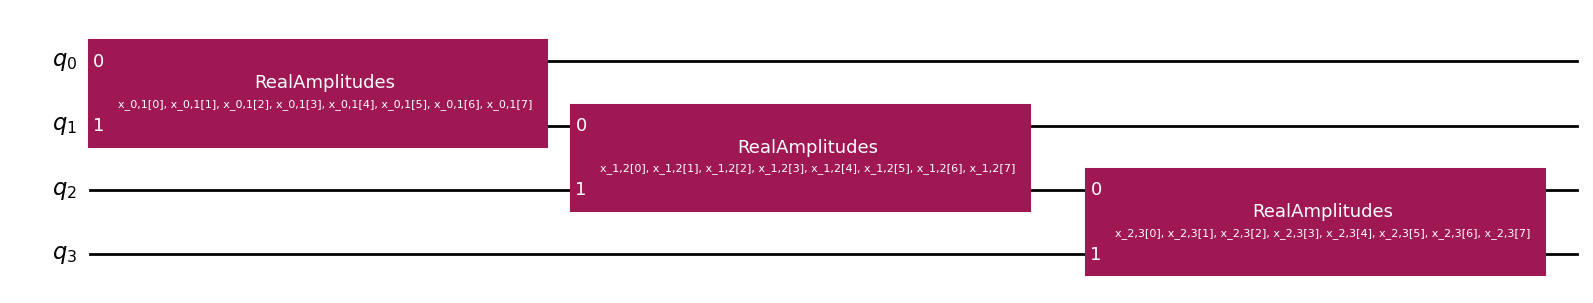

In [713]:
def MPS(num_qubits,parameter_prefix="x", **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the 
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.
        
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)
    for i, j in zip(qubits[:-1], qubits[1:]):
        block = RealAmplitudes(2, parameter_prefix=f"{parameter_prefix}_{i},{j}", **kwargs)
        qc.compose(block, [i, j], inplace=True)
        # if i < num_qubits - 2:
        #     qc.barrier()
    return qc

MPS(4).draw('mpl')

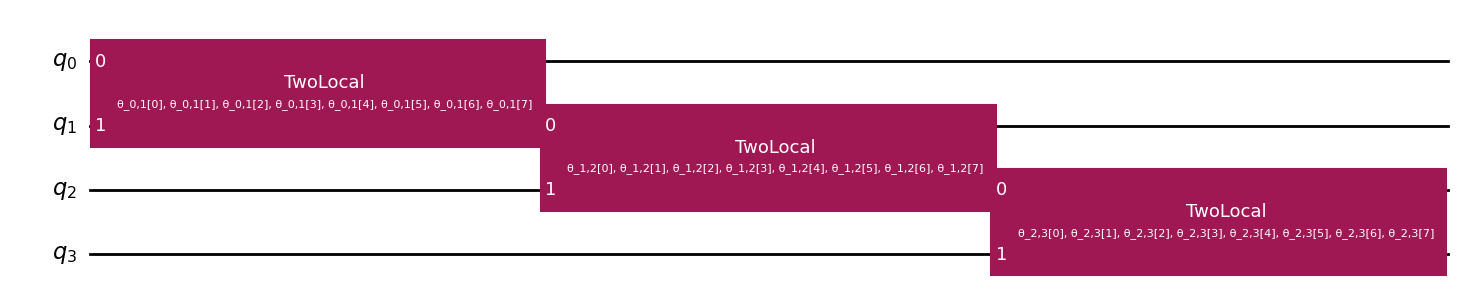

In [714]:
def TwoLocalMPS(num_qubits,parameter_prefix="θ", **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit using TwoLocal.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to TwoLocal.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.
        
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)
    for i, j in zip(qubits[:-1], qubits[1:]):
        block = TwoLocal(
            2,
            rotation_blocks='rx',
            entanglement='reverse_linear',
            entanglement_blocks='cx',
            parameter_prefix=f'{parameter_prefix}_{i},{j}',
            insert_barriers=True,
            **kwargs

        )
        qc.compose(block, [i, j], inplace=True)
    return qc

TwoLocalMPS(4).draw('mpl')

In [715]:
def create_ansatz(num_qubits, parameter_prefix="θ", ansatz_type="MPS", **kwargs):
    """
    Crea un ansatz del tipo specificato.
    
    Args:
        num_qubits (int): Numero di qubit.
        parameter_prefix (str): Prefisso per i parametri.
        ansatz_type (str): Tipo di ansatz - "MPS" (RealAmplitudes) o "TwoLocalMPS" (TwoLocal).
        **kwargs: Argomenti aggiuntivi passati alla funzione ansatz.
    
    Returns:
        QuantumCircuit: Il circuito ansatz.
    """
    if ansatz_type == "MPS":
        return MPS(num_qubits, parameter_prefix=parameter_prefix, **kwargs)
    elif ansatz_type == "TwoLocalMPS":
        return TwoLocalMPS(num_qubits, parameter_prefix=parameter_prefix, **kwargs)
    else:
        raise ValueError(f"Ansatz type '{ansatz_type}' non supportato. Usa 'MPS' o 'TwoLocalMPS'.")

# CIRCUITS

### Definizione del circuito originale ( Con RealAmplitudes + Pooling)

Decommentare l'encoding necessario per poter effettuare gli esperimenti opportuni


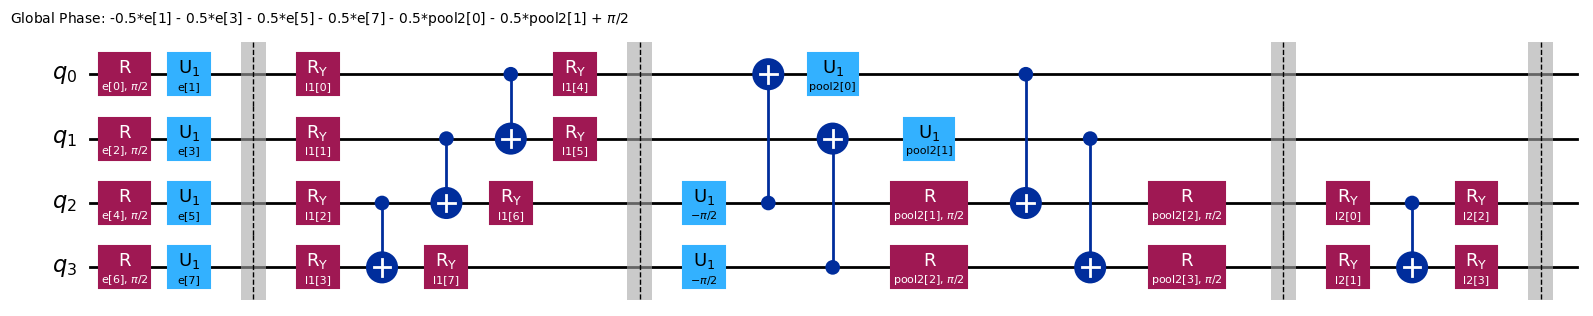

In [716]:
encoding = yz_angles_encoding(8, param_name="e")
#encoding = hRyRx_encoding(8)
#encoding= hRyRz_encoding(8)
#encoding = RyRx_encoding(8)





ansatz = QuantumCircuit(4)
ansatz.barrier()
############################2#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=4, reps=1, name="Layer1", parameter_prefix="l1"))
ansatz.barrier()
############################3#######################
ansatz = ansatz.compose(pooling_layer(4, "pool2"))
ansatz.barrier()
############################4#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=2, reps=1, name="Layer2",parameter_prefix="l2"), qubits=[2,3])
ansatz.barrier()

ansatz.decompose().draw(output="mpl")


qnn = QuantumCircuit(4).compose(encoding).compose(ansatz)

display(qnn.decompose().draw("mpl"))



### Circuito con TN (solo MPS)

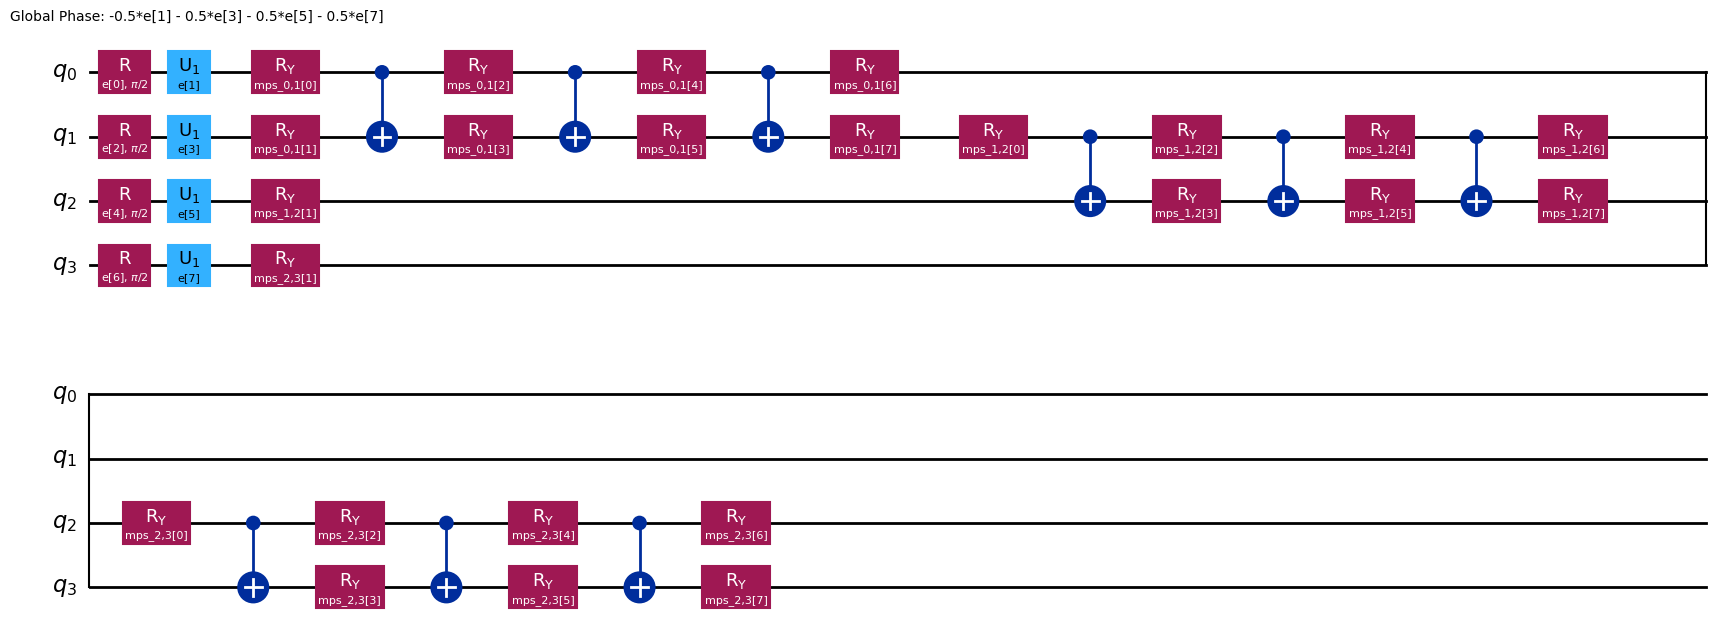

In [717]:
encoding = yz_angles_encoding(8, param_name="e")


qnn = QuantumCircuit(4).compose(encoding)

# Aggiunta dell'MPS al circuito
ansatz = MPS(num_qubits=4, parameter_prefix="mps")
qnn = qnn.compose(ansatz)

# Visualizzazione del circuito
display(qnn.decompose().draw("mpl"))

In [718]:
print("Encoding parameters:", len(encoding.parameters))
print("Ansatz parameters:", len(ansatz.parameters))
print("Total parameters in circuit:", len(qnn.parameters))

Encoding parameters: 8
Ansatz parameters: 24
Total parameters in circuit: 32


### Standard reuploading circuit

Circuito con encoder: None, ansatz: MPS


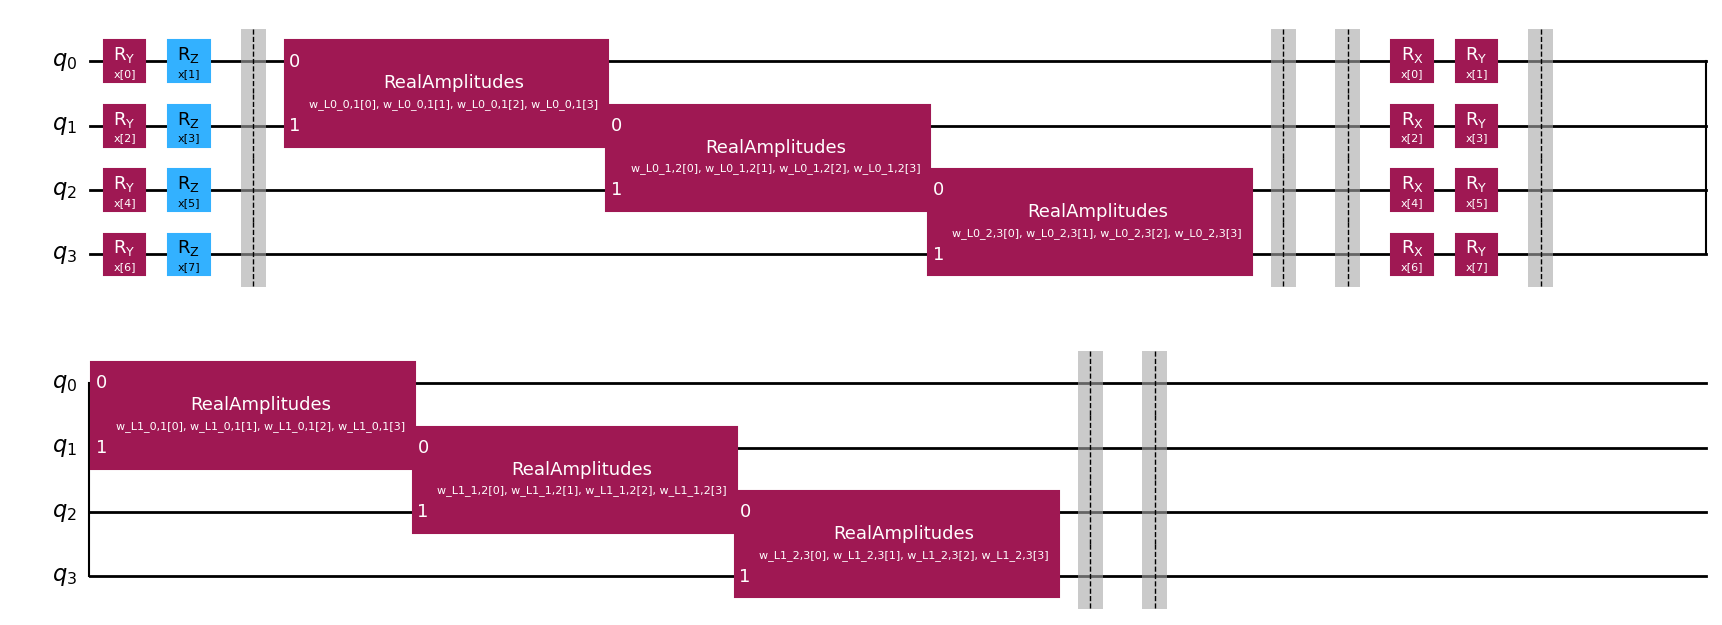

In [719]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
import math

def build_mps_reuploading_model(n_features, layers=2, fixed_encoder=None, ansatz_type="MPS"):
    """
    Costruisce un classificatore Re-uploading usando combinazioni di encoder e ansatz.
    
    Args:
        n_features (int): Numero di dati in input.
        layers (int): Quante volte ripetere la sequenza [Encoder -> Ansatz] (default=2).
        ansatz_type (str): Tipo di ansatz - "MPS" o "TwoLocalMPS" (default="MPS").
        fixed_encoder (str): Se None, cicla tra i tre encoder (yz, RxRy, RzRx).
                            Se specificato, usa lo stesso encoder per tutti i layer.
                            Opzioni: "yz", "RxRy", "RzRx", "RxRz", "RyRx" (default=None).
    """
    
    # Calcoliamo il numero di qubit necessari
    n_qubits = math.ceil(n_features / 2)
    
    # Inizializziamo il circuito finale
    full_qc = QuantumCircuit(n_qubits, name=f"{ansatz_type} Re-uploading Classifier")
    
    # Creiamo i parametri di input UNA VOLTA SOLA (condivisi tra tutti i layer)
    input_params = ParameterVector("x", n_features)
    
    # Ciclo di Re-uploading (Sandwich)
    for layer in range(layers):
        
        # --- A. Aggiungiamo l'Encoder ---
        if fixed_encoder is None:
            # Comportamento ciclico: cicla tra i tre encoder
            encoder_choice = layer % 3
            
            if encoder_choice == 0:
                # YZ encoding (RY, RZ)
                encoder_block = yz_angles_encoding(n_features, params=input_params)
            elif encoder_choice == 1:
                # RX-RY encoding (RX, RY)
                encoder_block = RxRy_encoding(n_features, params=input_params)
            else:
                # RZ-RX encoding (RZ, RX)
                encoder_block = RzRx_encoding(n_features, params=input_params)
        else:
            # Usa l'encoder fisso specificato per tutti i layer
            if fixed_encoder == "yz":
                encoder_block = yz_angles_encoding(n_features, params=input_params)
            elif fixed_encoder == "RxRy":
                encoder_block = RxRy_encoding(n_features, params=input_params)
            elif fixed_encoder == "RxRz":
                encoder_block = RxRz_encoding(n_features, params=input_params)
            elif fixed_encoder == "RyRx":
                encoder_block = RyRx_encoding(n_features, params=input_params)
            elif fixed_encoder == "RzRx":
                encoder_block = RzRx_encoding(n_features, params=input_params)
            else:
                raise ValueError(f"Encoder '{fixed_encoder}' non supportato. "
                               "Usa: 'yz', 'RxRy', 'RxRz', 'RyRx', 'RzRx' o None per il comportamento ciclico.")

        full_qc.compose(encoder_block, inplace=True)
        full_qc.barrier()
        
        # --- B. Aggiungiamo l'Ansatz (MPS o TwoLocalMPS) ---
        ansatz_block = create_ansatz(n_qubits, parameter_prefix=f"w_L{layer}", ansatz_type=ansatz_type, reps=1)
        full_qc.compose(ansatz_block, inplace=True)
        
        full_qc.barrier()
        full_qc.barrier()

    return full_qc

# --- TEST ---
# Supponiamo 8 feature e 2 livelli di profondità

ansatz_type = "MPS"  # Scegli tra "MPS" e "TwoLocalMPS"
fixed_enc = None  # Scegli tra None (ciclico), "yz", "RxRy", "RxRz", "RyRx", "RzRx"
qnn_std_reupload = build_mps_reuploading_model(n_features=8, layers=2, fixed_encoder=fixed_enc, ansatz_type=ansatz_type)

# Disegniamo il risultato
print(f"Circuito con encoder: {fixed_enc}, ansatz: {ansatz_type}")
qnn_std_reupload.draw(output="mpl")

### Partial reuploading circuit

=== Test Sequential Sliding Window ===
Configurazione: 4 qubit, 3 layer, 4 feature/layer, encoder: RxRz
Feature totali mappate: 12


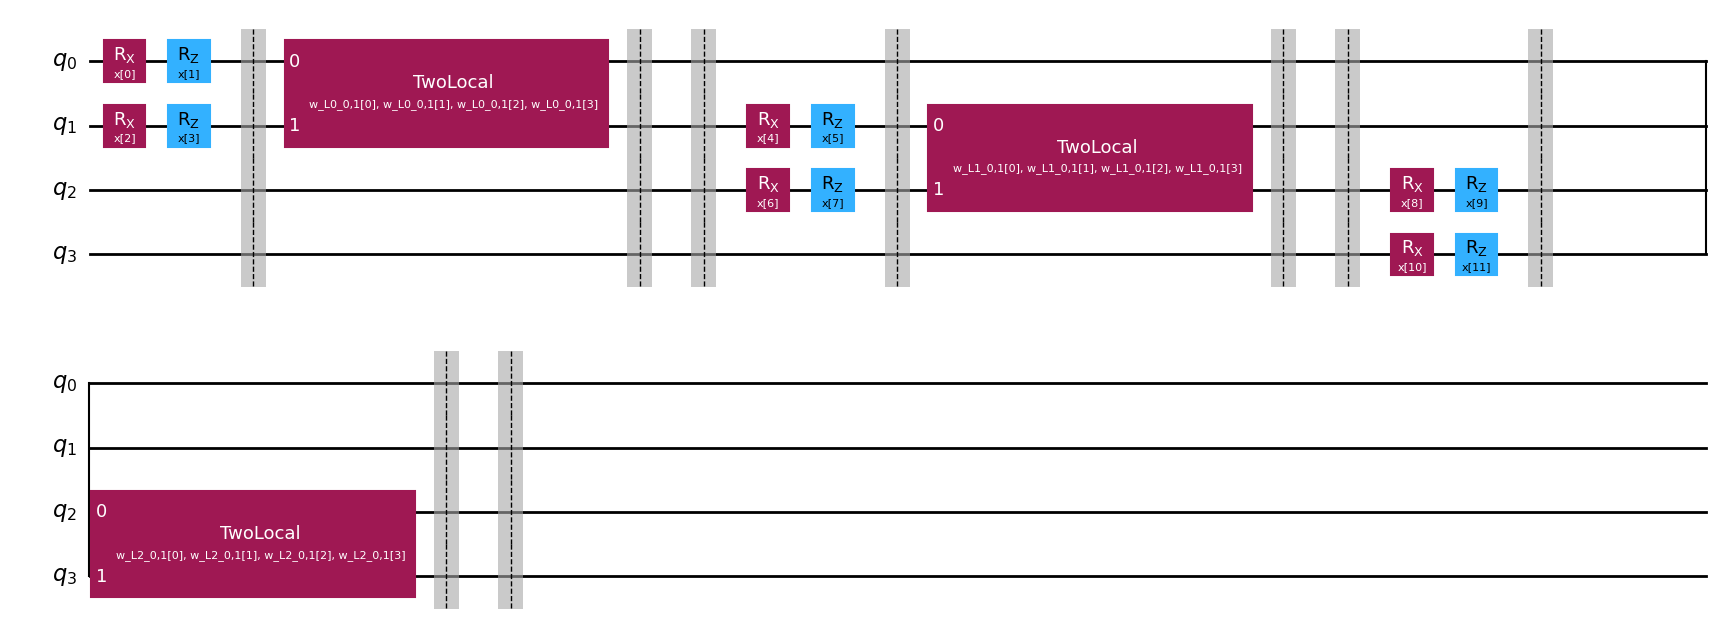

In [720]:
def build_partial_mps_model(n_features, layers=3, features_per_layer=4, fixed_encoder="yz", ansatz_type="MPS"):
    """
    Costruisce un classificatore Sequential Partial con finestra scorrevole.
    Ogni layer carica feature DIVERSE su qubit sovrapposti in modo sequenziale.
    
    Esempio con 4 qubit, 3 layer, 4 feature/layer:
    - Layer 0: feature 0-3  → qubit (0,1)
    - Layer 1: feature 4-7  → qubit (1,2)  
    - Layer 2: feature 8-11 → qubit (2,3)
    Totale: 12 feature mappate!
    
    Args:
        n_features (int): Numero TOTALE di feature da mappare (aumentato rispetto al caso standard).
        layers (int): Numero di blocchi [Encoding -> Ansatz].
        features_per_layer (int): Quante feature caricare in ogni layer (deve essere pari).
        ansatz_type (str): Tipo di ansatz - "MPS" o "TwoLocalMPS" (default="MPS").
        fixed_encoder (str): Encoder da usare per tutti i layer.
                            Opzioni: "yz", "RxRy", "RxRz", "RyRx", "RzRx" (default="yz").
    """
    
    # Assicurati che le feature per layer siano un numero pari
    if features_per_layer % 2 != 0:
        features_per_layer += 1
        print(f"Adattato features_per_layer a {features_per_layer} per l'encoding a coppie.")
    
    # Validazione encoder
    valid_encoders = {"yz", "RxRy", "RxRz", "RyRx", "RzRx"}
    if fixed_encoder not in valid_encoders:
        raise ValueError(f"Encoder '{fixed_encoder}' non supportato. "
                        f"Usa: {valid_encoders}")
    
    # Mappa encoder a coppie di gate (gate1, gate2)
    encoder_gates = {
        "yz": ("ry", "rz"),
        "RxRy": ("rx", "ry"),
        "RxRz": ("rx", "rz"),
        "RyRx": ("ry", "rx"),
        "RzRx": ("rz", "rx"),
    }
    gate1_name, gate2_name = encoder_gates[fixed_encoder]
    
    # Calcolo del numero di qubit necessari per la finestra scorrevole
    # Primo layer usa features_per_layer/2 qubit, poi ogni layer aggiunge 1 qubit
    n_qubits_per_encoding = math.ceil(features_per_layer / 2)
    n_qubits = n_qubits_per_encoding + (layers - 1)
    
    # Calcola il numero totale di feature che verranno mappate
    total_features_mapped = layers * features_per_layer
    
    if n_features < total_features_mapped:
        print(f"ATTENZIONE: Con {layers} layer e {features_per_layer} feature/layer,")
        print(f"verranno mappate {total_features_mapped} feature totali.")
        print(f"Aumenta n_features a {total_features_mapped} o riduci layers/features_per_layer.")
    
    # Inizializziamo il circuito
    full_qc = QuantumCircuit(n_qubits, name=f"Sequential Sliding Window ({fixed_encoder})")
    input_params = ParameterVector("x", total_features_mapped)
    
    print(f"Configurazione: {n_qubits} qubit, {layers} layer, {features_per_layer} feature/layer, encoder: {fixed_encoder}")
    print(f"Feature totali mappate: {total_features_mapped}")
    
    for layer in range(layers):
        
        # --- A. ENCODER SEQUENZIALE A FINESTRA SCORREVOLE ---
        # Calcola l'offset dei qubit per questo layer (finestra scorrevole)
        qubit_offset = layer
        
        # Calcola l'indice di partenza delle feature per questo layer (sequenziale, non ciclico)
        start_feature_idx = layer * features_per_layer
        
        # Carica il blocco di feature sui qubit della finestra corrente
        feature_idx = 0
        for i in range(n_qubits_per_encoding):
            qubit_target = qubit_offset + i
            
            p_idx_1 = start_feature_idx + feature_idx
            p_idx_2 = start_feature_idx + feature_idx + 1
            
            # Applica i gate solo se l'indice è valido
            if p_idx_1 < total_features_mapped:
                getattr(full_qc, gate1_name)(input_params[p_idx_1], qubit_target)
            if p_idx_2 < total_features_mapped:
                getattr(full_qc, gate2_name)(input_params[p_idx_2], qubit_target)
            
            feature_idx += 2
        
        full_qc.barrier()
        
        # --- B. ANSATZ (MPS o TwoLocalMPS) solo sui qubit popolati in questo layer ---
        # Calcola i qubit usati in questo layer
        qubits_in_layer = list(range(qubit_offset, qubit_offset + n_qubits_per_encoding))
        ansatz_block = create_ansatz(n_qubits_per_encoding, parameter_prefix=f"w_L{layer}", ansatz_type=ansatz_type, reps=1)
        full_qc.compose(ansatz_block, qubits_in_layer, inplace=True)
        
        full_qc.barrier()
        full_qc.barrier()
    
    return full_qc

# --- TEST ---
# Con 3 layer e 4 feature/layer, mappiamo 12 feature totali su 4 qubit
# Cambia ansatz_type="TwoLocalMPS" per usare TwoLocal invece di RealAmplitudes
# Scegli l'encoder: "yz", "RxRy", "RxRz", "RyRx", "RzRx"
print("=== Test Sequential Sliding Window ===")
qnn_partial_reupload = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4, 
                                               fixed_encoder="RxRz", ansatz_type="TwoLocalMPS")

qnn_partial_reupload.draw(output="mpl")

# HYBRID NETWORKS



### 8-features per image

In [721]:
from qiskit.primitives import Sampler
def parity(x):
    return f"{bin(x)}".count("1")

# SCELTA DEL CIRCUITO QUANTISTICO
qnn_circuit_8 = build_mps_reuploading_model(n_features=8, layers=2, ansatz_type="TwoLocalMPS")

# Separa i parametri: i primi 8 sono input, il resto sono weight dall'ansatz MPS
input_ps_8 = list(qnn_circuit_8.parameters)[:8]
weight_ps_8 = list(qnn_circuit_8.parameters)[8:]

qmodel_8 = SamplerQNN(
    circuit=qnn_circuit_8,
    input_params=input_ps_8,
    weight_params=weight_ps_8,
    input_gradients=True
)


class HybridRegressorConvNet8Features(nn.Module):
    def __init__(self, qm1):
        super().__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5)),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        
        self.reduction = nn.Sequential(
            nn.Linear(in_features=576, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=8)
        )
     
        self.final = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),

        )

        self.q1 = TorchConnector(qm1)
    

    def forward(self, x):

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)

        x = self.flatten(x)

        x = self.reduction(x)

        #Per encoding con HRyRz
        #x = x * (math.pi / 2)
        #x= self.q1(x)
        
        x = self.q1(x) * 100

        x = self.final(x)

        return x
    

distance_model_8 = HybridRegressorConvNet8Features(qmodel_8)
distance_model_8 = distance_model_8.to(device)
summary(distance_model_8, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                    [-1, 8]             968
   TorchConnector-13                   [-1, 16]              24
           Linear-14                   

### 12-features per image

In [722]:
from qiskit.primitives import Sampler

# SCELTA DEL CIRCUITO QUANTISTICO PER 12 FEATURES
qnn_circuit_12 = build_partial_mps_model(n_features=12, layers=3, features_per_layer=4, ansatz_type="TwoLocalMPS")

# Separa i parametri: i primi 12 sono input, il resto sono weight dall'ansatz RealAmplitudes
input_ps_12 = list(qnn_circuit_12.parameters)[:12]
weight_ps_12 = list(qnn_circuit_12.parameters)[12:]

qmodel_12 = SamplerQNN(
    circuit=qnn_circuit_12,
    input_params=input_ps_12,
    weight_params=weight_ps_12,
    input_gradients=True
)


class HybridRegressorConvNet12Features(nn.Module):
    def __init__(self, qm1):
        super().__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5)),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        
        # Riduzione a 12 feature invece di 8
        self.reduction = nn.Sequential(
            nn.Linear(in_features=576, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=12)
        )
     
        # Output layer (da 16 a 16 qubit output)
        self.final = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),
        )

        self.q1 = TorchConnector(qm1)
    

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)

        x = self.flatten(x)
        x = self.reduction(x)
        
        x = self.q1(x) * 100
        x = self.final(x)

        return x
    

distance_model_12 = HybridRegressorConvNet12Features(qmodel_12)
distance_model_12 = distance_model_12.to(device)
summary(distance_model_12, input_size=(1,28,28))

Configurazione: 4 qubit, 3 layer, 4 feature/layer, encoder: yz
Feature totali mappate: 12
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 12]           1,452
   TorchConne

# TRAIN

### Training setup

In [723]:
n_features = 12
if n_features == 8:
    model_to_train = qmodel_8
    distance_model = HybridRegressorConvNet8Features(model_to_train)
else:
    model_to_train = qmodel_12
    distance_model = HybridRegressorConvNet12Features(model_to_train)
training_dataloader = DataLoader(t, batch_size=8, shuffle=True)
val_data_loader = DataLoader(v, batch_size=8, shuffle=True)
distance_model = distance_model.to(device)
optimizer = torch.optim.SGD(distance_model.parameters(), lr=1e-2)
loss = torch.nn.TripletMarginLoss(margin=2)
epochs = 100

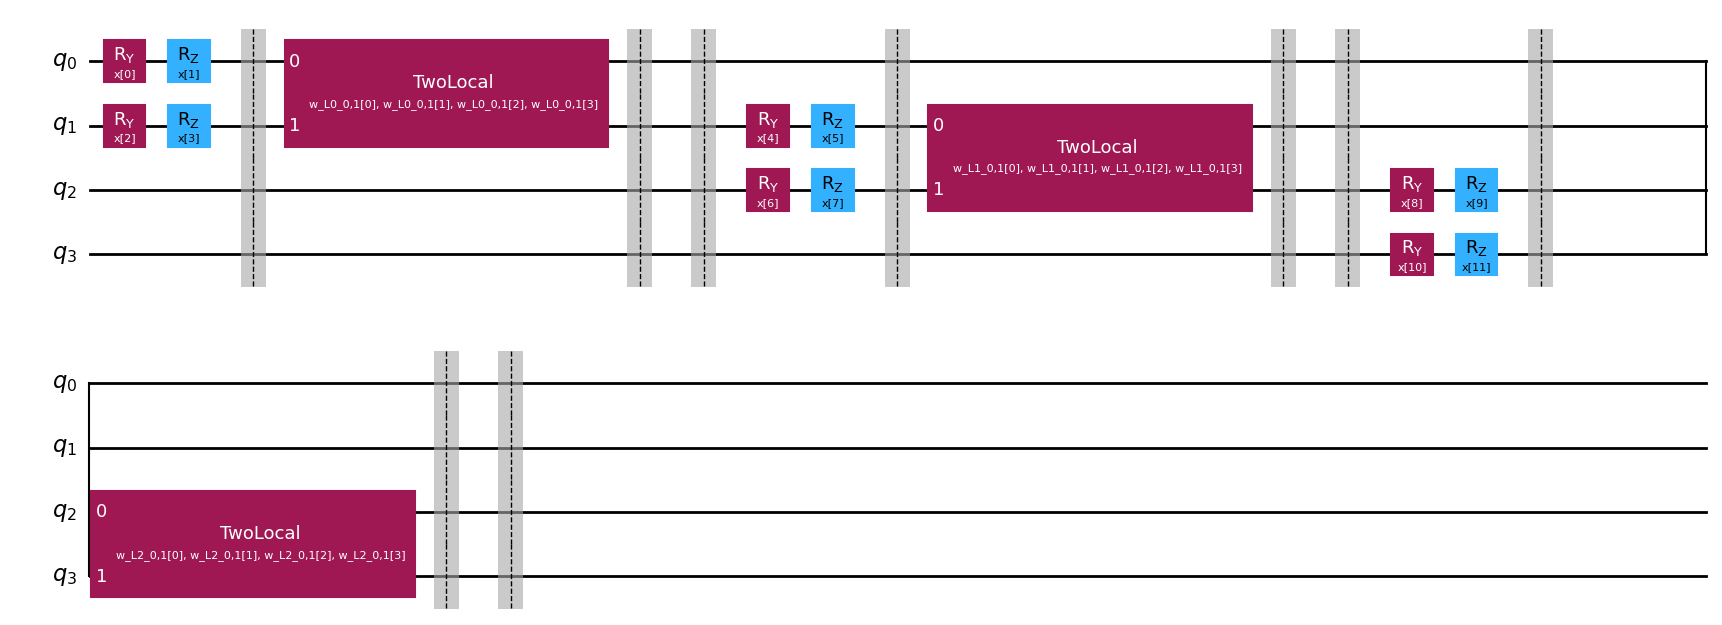

In [724]:
model_to_train.circuit.draw(output="mpl")

### Training loop

In [725]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, validation_step=False, print_at=1, seed= 42):

    
    set_seed(seed)
    for epoch in range(epochs):
        set_seed(seed + epoch)
        
        prnt = (epoch % print_at) != 0 if epoch!=(epochs-1) else False


        if not(prnt):
            print(f"{color.BOLD}Epoch {color.END}{epoch+1}")

        ### --> Training Phase

        model.train()

        train_loss = 0.0
        train_samples = 0

        

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()


            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)


            e_A = model(anchor)
            e_P = model(positive)
            e_N = model(negative)


            

            loss = criterion(e_A, e_P, e_N)

            loss.backward()
            optimizer.step()

            train_loss += loss 
            train_samples += positive.size(0)


        train_loss /= len(train_data_loader)
        
        if not(prnt):
            print(f"TRAINING   -> Loss: {train_loss:2.6f}")
            print("")    

### Training loop with early stopping


In [726]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, 
          validation_step=False, print_at=1, early_stopping_patience=3, 
          min_delta=0.001, restore_best_weights=True, seed=42):
    
    set_seed(seed)
    best_loss = float('inf')
    no_improvement_count = 0
    best_model_state = None

    for epoch in range(epochs):
        
        set_seed(seed + epoch)
        prnt = (epoch % print_at) != 0 if epoch != (epochs-1) else False

        # Inizializza early_stopping_triggered all'inizio di ogni epoch
        early_stopping_triggered = False

        if not prnt:
            print(f"{color.BOLD}Epoch {color.END}{epoch+1}")

        ### --> Training Phase
        model.train()
        train_loss = 0.0
        train_samples = 0

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            e_A = model(anchor)
            e_P = model(positive)
            e_N = model(negative)

            loss = criterion(e_A, e_P, e_N)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_samples += positive.size(0)

        train_loss /= len(train_data_loader)
        
        ### --> Validation Phase (solo se richiesto)
        val_loss = 0.0
        if validation_step and not prnt:
            model.eval()
            with torch.no_grad():
                for anchor, positive, negative in val_data_loader:
                    anchor = anchor.to(device)
                    positive = positive.to(device)
                    negative = negative.to(device)

                    e_A = model(anchor)
                    e_P = model(positive)
                    e_N = model(negative)

                    loss = criterion(e_A, e_P, e_N)
                    val_loss += loss.item()

                val_loss /= len(val_data_loader)

        ### --> Early Stopping Logic
        if validation_step and not prnt:
            # Controlla miglioramento
            if (best_loss - val_loss) > min_delta:
                best_epoch = epoch
                best_loss = val_loss
                no_improvement_count = 0
                # Salva lo stato del modello migliore
                if restore_best_weights:
                    print("Best epoch: ", best_epoch)
                    best_model_state = model.state_dict().copy()
            else:
                no_improvement_count += 1
                if no_improvement_count >= early_stopping_patience:
                    print(f"\n{color.RED}Early stopping at epoch {epoch+1}{color.END}")
                    early_stopping_triggered = True

        ### --> Stampa risultati
        if not prnt:
            log_str = f"TRAINING   -> Loss: {train_loss:2.6f}"
            if validation_step:
                log_str += f" | VALIDATION -> Loss: {val_loss:2.6f}"
            print(log_str)
            print("")

        ### --> Interrompi il training se early stopping
        if early_stopping_triggered:
            break

    ### --> Ripristina i migliori pesi se richiesto
    if restore_best_weights and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{color.GREEN}Restored best model weights{color.END}")

    return model

### Train execution

In [727]:
#Train senza Early Stopping

train(
    model=distance_model,
    epochs=2,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=None,
    validation_step=False,
    device=device,
    print_at=1,
    seed=42
)


#Train con Early Stopping
'''
distance_model = train(
    distance_model,
    epochs=100,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=val_data_loader,
    device=device,
    validation_step=True,
    early_stopping_patience=4,
    min_delta=0.005,
    seed=42
)
'''

#save the model
with open(r"models/triplet_loss/QuantumTripletLossMNIST_TTN.pt", "wb") as f:
    torch.save(distance_model.state_dict(), f)

Epoch 1


100%|██████████| 38/38 [01:37<00:00,  2.56s/it]


TRAINING   -> Loss: 1.554295

Epoch 2


100%|██████████| 38/38 [01:33<00:00,  2.47s/it]

TRAINING   -> Loss: 1.388270



In [728]:
#save the model
with open(r"models/triplet_loss/QuantumTripletLossMNIST_TTN.pt", "wb") as f:
    torch.save(distance_model.state_dict(), f)

# EVALUATION

In [729]:
with open(r"models/triplet_loss/QuantumTripletLossMNIST_TTN.pt", "rb") as f:
    distance_model.load_state_dict(torch.load(f))
distance_model

HybridRegressorConvNet12Features(
  (conv_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (reduction): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=12, bias=True)
  )
  (final): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (q1): TorchConnector()
)

In [730]:
training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

with torch.no_grad():
    distance_model.eval()
    embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(training_dataloader):
        anchor = anchor.to(device)
        embedding_data = np.concatenate((embedding_data,distance_model(anchor).to(device).squeeze(0).numpy()), axis=0)

100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


In [731]:
#confronto tra la distanza dei dati originali e la distanza dei dati embending ottenuiti tramite il modello ibrido
baseline_distance = metrics.pairwise_distances(t.get_flatten())
learned_distance = metrics.pairwise_distances(embedding_data)

In [732]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(learned_distance)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.361
Purity:        0.443


In [733]:
quantum_clustering = KMeans(n_clusters=10,  init='k-means++', n_init=10,random_state=42)
quantum_prediction = quantum_clustering.fit_predict(embedding_data)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.422
Purity:        0.470


In [734]:
training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

with torch.no_grad():
    distance_model.eval()
    if n_features == 8:
        clustering_data = np.empty((0,8))
    else:
        clustering_data = np.empty((0,12))
    for anchor, _,_ in tqdm(training_dataloader):
        x = anchor.to(device)
        x = distance_model.conv_1(x)
        x = distance_model.conv_2(x)
        x = distance_model.conv_3(x)
        x = distance_model.flatten(x)
        x = distance_model.reduction(x)
        clustering_data = np.concatenate((clustering_data,x.to(device).squeeze(0).numpy()), axis=0)

clustering_data.shape

100%|██████████| 30/30 [00:00<00:00, 264.33it/s]


(300, 12)

In [735]:
from qiskit import ClassicalRegister
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit.visualization import plot_histogram

#quantum_w è un insieme di pesi ottenuti da distance_model.q1. Viene trasformato in un array NumPy e usato nei parametri del circuito.
#qemb_circuit è il circuito quantistico associato alla rete neurale quantistica.
quantum_w = distance_model.q1.weight.detach().to(device).numpy()
qemb_circuit = distance_model.q1.neural_network.circuit

def quantum_embedding_distance(x,y):
    '''
    base: Un registro quantistico di 8 qubit per rappresentare i dati.
    ancilla: Un singolo qubit ausiliario necessario per lo SWAP test.
    classical: Un registro classico per immagazzinare il risultato della misura.
    swap_circuit: Il circuito quantistico che eseguirà il test.
    '''
    base = QuantumRegister(8, "data")
    ancilla = QuantumRegister(1, 'ancilla')
    classical = ClassicalRegister(1, 'output')
    swap_circuit = QuantumCircuit(base, ancilla, classical)

    '''
    w1 e w2 sono le versioni estese dei vettori x e y, a cui vengono aggiunti i pesi quantum_w.
    q1 e q2 sono i circuiti parametrizzati con w1 e w2, che rappresentano gli stati quantistici degli embedding.
    '''
    w1 = np.append(x, quantum_w)
    w2 = np.append(y, quantum_w)

    q1 = qemb_circuit.assign_parameters(w1)
    q2 = qemb_circuit.assign_parameters(w2)

    '''
    q1 viene caricato nei primi 4 qubit del registro base.
    q2 viene caricato nei secondi 4 qubit del registro base.
    A questo punto, il circuito ha due stati quantistici distinti |ψ1⟩ e |ψ2⟩ caricati nei primi 4 e ultimi 4 qubit.
    '''
    swap_circuit = swap_circuit.compose(q1, [0,1,2,3])
    swap_circuit = swap_circuit.compose(q2, [4,5,6,7])

    # Implementazione dello SWAP test, serve per misurare la somiglianza tra i due stati quantistici |ψ1⟩ e |ψ2⟩.
    swap_circuit.barrier()

    swap_circuit.h(ancilla)
    swap_circuit.cswap(ancilla, 0,4)
    swap_circuit.cswap(ancilla, 1,5)
    swap_circuit.cswap(ancilla, 2,6)
    swap_circuit.cswap(ancilla, 3,7)
    swap_circuit.h(ancilla)
    # Misura l'ancilla e memorizza il risultato nel registro classico.
    swap_circuit.measure(ancilla,classical)

    backend = BasicProvider().get_backend('basic_simulator')
    qc = transpile(swap_circuit, backend)
    result = backend.run(qc, shots=1000).result().get_counts(qc).get('1',0)

    ret = result
    return ret


quantum_embedding_distance(clustering_data[16], clustering_data[8])

1

# Sezione Test Del Modello

In [736]:
t_test = MNIST_Distance_Dataset_Triplet_Loss(X_test, y_test)
t_test_loader = DataLoader(t_test, batch_size=128, shuffle=False)
with torch.no_grad():
    distance_model.eval()
    test_embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(t_test_loader):
        anchor = anchor.to(device)
        test_embedding_data = np.concatenate((test_embedding_data, distance_model(anchor).to(device).squeeze(0).numpy()), axis=0)

reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)
reduction_model_embedding = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t_test.get_flatten())
vis_x_embed = reduction_model_embedding.fit_transform(test_embedding_data)

100%|██████████| 79/79 [00:31<00:00,  2.52it/s]


In [737]:
print("QUANTUM AGGLOMERATIVE CLUSTERING")
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
quantum_prediction1 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction1, t_test.target)

QUANTUM AGGLOMERATIVE CLUSTERING
Silhouette:    0.301
Purity:        0.382


In [738]:
print("QUANTUM KMEANS CLUSTERING")
quantum_clustering = KMeans(n_clusters=10, init="k-means++",n_init=10,random_state=42)
quantum_prediction2 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction2, t_test.target)

QUANTUM KMEANS CLUSTERING
Silhouette:    0.384
Purity:        0.451


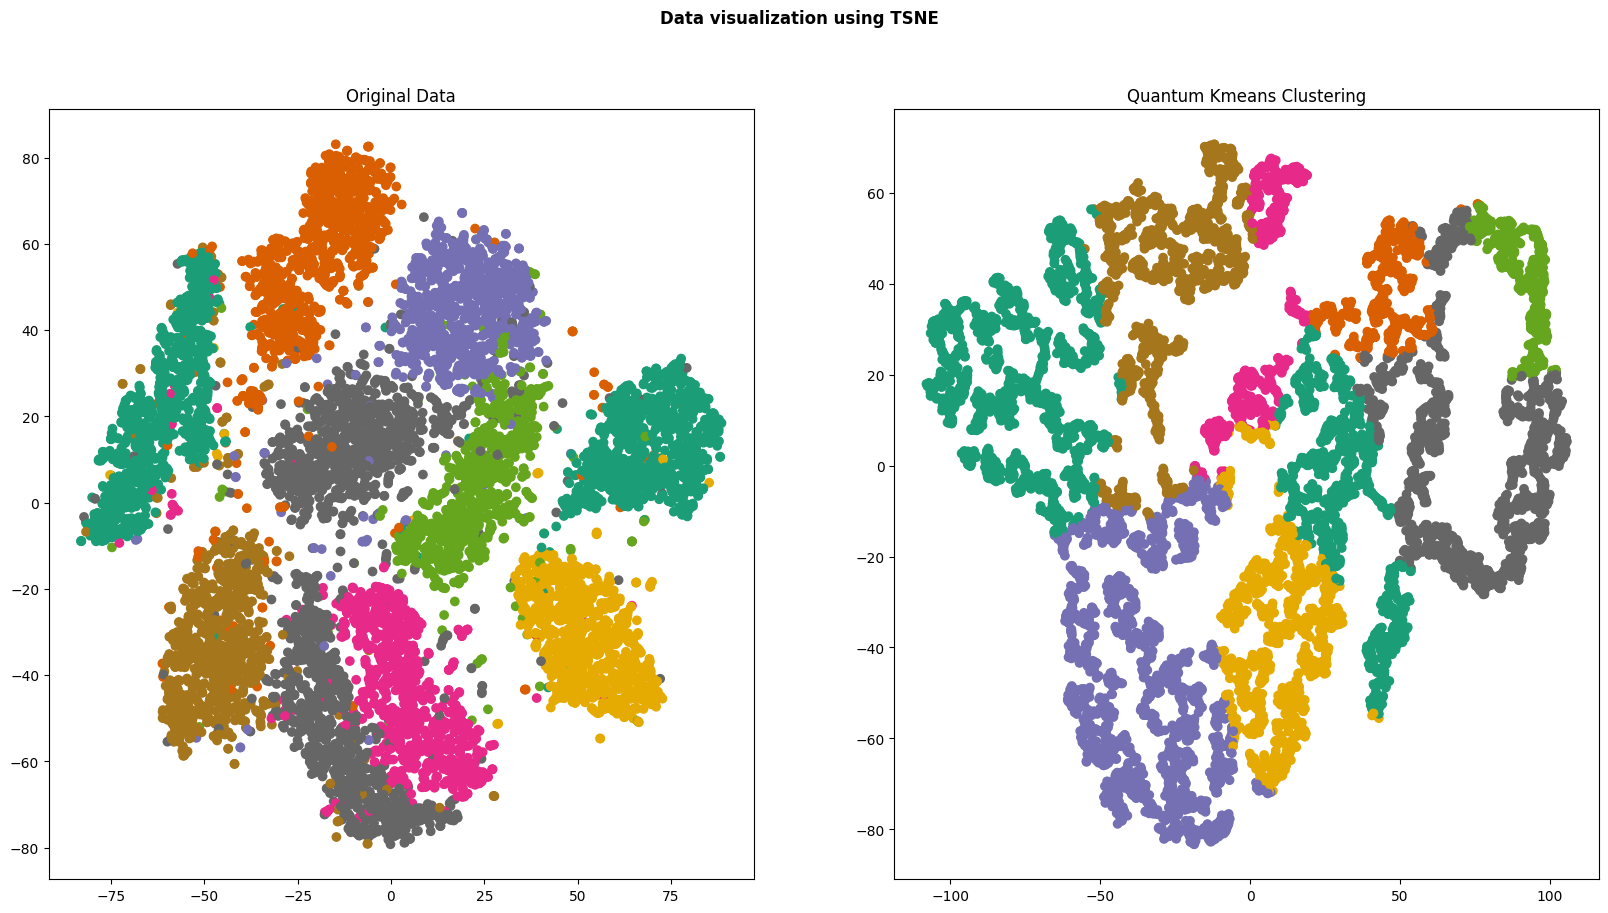

In [739]:
#Visualize the cluserting
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Data visualization using TSNE", weight="bold")
ax[0].scatter(vis_x[:,0], vis_x[:,1], c=t_test.target[:len(vis_x)], cmap='Dark2')
ax[0].set_title("Original Data")
ax[1].scatter(vis_x_embed[:,0], vis_x_embed[:,1], c=quantum_prediction2, cmap='Dark2')
ax[1].set_title("Quantum Kmeans Clustering")
plt.show()